# Use glhmm to decode images

The goal of this analysis is to train decoders on localizer trials, and apply the trained decoders on main task trials. Exact details of the study is specified in 
> Zhou, Y. J., Pérez-Bellido, A., Haegens, S., & de Lange, F. P. (2020). Perceptual expectations modulate low-frequency activity: A statistical learning magnetoencephalography study. Journal of Cognitive Neuroscience, 32(4), 691-702.

In this experiment, participants first learned the pairing of images (e.g., LeadImage1 always followed by TrailImage1, LeadImage2 always followed by TrailImage2 etc.), and then they went into the MEG scanner to complete the main task trials and the localizer trials. 
<br>
<br>
The critical manipulation in the main task trials is that, in the scanner, these Lead- and Trail- images were presented in either:
- **E**xpected way, i.e., LeadImage1 follwed by TrailImage1, LeadImage2 followed by TrailImage2 etc.
- **U**xpected way, i.e., LeadImage1 followed by LeadImages other than LeadImage1, LeadImage2 followed by TrailImage other than TrailImage2 etc.

#### Brief description of the main task trials
In each trial, two images are presented. Here, we refer to the first image "LeadImage" and second image "TrailImage". The LeadImage was presented for 500ms, a 300-ms blank screen then followed, then the TrailImage was presented for 500ms, then the trial ended with a >800ms blank screen.  

#### Brief description of the localizer trials
We presented all the LeadImages in a randomized order. In each trial, the LeadImage was on for 500ms, and then a >800ms blank screen (before showing the next image).

In [1]:
import mne
import pickle
import numpy as np
import matplotlib.pyplot as plt
from glhmm import glhmm, utils, preproc, auxiliary
from JY_glhmm_utils import (row_to_matrix, apply_pca)
from JY_glhmm_utils import (get_predicted, 
                            get_classification_correctness, 
                            get_state_evoked_response, 
                            get_conditioned_metric)

In [2]:
# Subject ID
subject = "sub401"

# Directories
PROJ_DIR  = "/Volumes/ExtDisk/DATA/3018041.01"
EPOCH_DIR = f"{PROJ_DIR}/derivatives/epochs"

We then set up the glhmm model by (a) specifying the number of states, (b) time window (locked to image onset) used to epoch the trials, and (c) the state path.
Here, the state path is set to "chain", such that each epoch is assumed to start always at the first state, and it goes sequentially from the first, second, ... to the fifth.  
<br>
**QUESTION:** Ideally, I'd like to include some pre-stimulus time window as "baseline", e.g., to set `twin = [-0.2, 1.0]` instead of `twin = [0, 1.0]`. This would allow us to get a sense of the baseline decodability, whether it is at chance level (1/6 in this case). But the question is, how do I set the `Pstructure` and `Pistructure` to constrain the HMM in a reasonable manner?

In [3]:
# Define numbers of states
K = 5

# Time-window used to epoch the data
twin = [0, 1.0]

# Options for training 
# cyc: maximum number of variational inference cycles. The algorithm will stop earlier if tol is reached. (Default to 1000).
# initrep: number of repetitions of the initialisation algorithm, out of which the best will be used as a starting point for the variational inference (default to 5).
options = {'cyc':1000, 'initrep':0}

# Constrain the state paths: set to "chain" as this is consistent with sensory processing
Pstructure = np.eye(K, dtype=bool)
for k in range(K-1): Pstructure[k,k+1] = True
Pistructure = np.zeros(K, dtype=bool)
Pistructure[0] = True #sequences are allowed to start with the first state
options['cyc'] = 1 #save time for the training

# Initialize the hmm
hmm = glhmm.glhmm(K=K,
        covtype='shareddiag',
        model_mean='no',
        model_beta='state', 
        Pistructure=Pistructure, 
        Pstructure=Pstructure,
        dirichlet_diag=100)

In [4]:
#============== Train on localizer trials =============
# Trials to use: no need to change
task = "loc"
stim = 'stimOn'

# read in the epochs
epoch_fname = f"{EPOCH_DIR}/{task}/{subject}_{stim}-epo.fif"
epochs = mne.read_epochs(epoch_fname, preload=True, verbose="INFO")

# sub-select channels and timepoints
epochs.pick(picks="meg")
epochs.crop(tmin=twin[0], tmax=twin[-1], include_tmax=False)

# update the metadata
epochs.metadata['trialtype'] = epochs.metadata['trialtype'].apply(lambda x: x[0] if isinstance(x, list) else x)

# concatenate trials: this is the X of a decoding model
info_trl = row_to_matrix( epochs["trialtype=='S'"].metadata['iTrailImg'].to_numpy() ) #resulting in (n_trials, n_stim-feature)
data_trl = epochs["trialtype=='S'"].get_data() #resulting in (n_trials, n_chan, n_times)
n_trials = data_trl.shape[0]
n_samples = data_trl.shape[-1]
print(f"info_trl.shape = {info_trl.shape}")
print(f"data_trl.shape = {data_trl.shape}")
print(f"data_trl consisting of {n_trials} trials, each trial has {n_samples} timepoints.")
data = []
info = []
for i in range(n_trials):
    info.append( np.tile( info_trl[i,:], (n_samples,1) ) ) #after `np.tile` we get (n_times, n_stim-features)
    data.append( data_trl[i,:,:].T ) #data_trl[i,:,:].T.shape is (n_times, n_chan)
X = np.vstack(data)
Y = np.vstack(info)

# indices
ind_ = auxiliary.make_indices_from_T(np.ones((n_trials,))*n_samples)

# preprocess
X,ind = preproc.preprocess_data(X, ind_, fs=epochs.info['sfreq'], standardise=True, 
                                filter=None, detrend=False, onpower=False, pca=None, downsample=None)

# PCA: takes the top PCs explaining 95% variance and saves the mixing matrix as `pcamodel` 
X, pcamodel = apply_pca(X, d=0.95)

# train hmm
hmm.train(X, Y, ind, options=options)

Reading /Volumes/ExtDisk/DATA/3018041.01/derivatives/epochs/loc/sub401_stimOn-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 4 columns
648 matching events found
No baseline correction applied
0 projection items activated


/var/folders/d6/6vfpk7b93pqbdh_08m49dc_r0000gn/T/ipykernel_84794/3415895656.py:19: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_trl = epochs["trialtype=='S'"].get_data() #resulting in (n_trials, n_chan, n_times)


info_trl.shape = (590, 6)
data_trl.shape = (590, 271, 250)
data_trl consisting of 590 trials, each trial has 250 timepoints.


(array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [1.00000000e+00, 3.23850319e-13, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [1.00000000e+00, 6.77673944e-13, 1.14686203e-20, 0.00000000e+00,
         0.00000000e+00],
        ...,
        [1.16482580e-12, 9.65057171e-01, 1.16140028e-03, 1.84636759e-03,
         3.19350615e-02],
        [1.15410935e-12, 9.64566648e-01, 1.57663518e-03, 1.90334452e-03,
         3.19533722e-02],
        [1.14688078e-12, 9.63002050e-01, 3.11969177e-03, 1.90636956e-03,
         3.19718890e-02]]),
 array([[[1.00000000e+00, 3.23850319e-13, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00

In [5]:
#============== Decode on main trials ===============
# Trials to use: no need to change
task = "main"
stim = 'stim1On'
tS2  = 0.8

# read in the epochs
epoch_fname = f"{EPOCH_DIR}/{task}/{subject}_{stim}-epo.fif"
epochs = mne.read_epochs(epoch_fname, preload=True, verbose="INFO")

# sub-select channels and timepoints
epochs.pick(picks="meg")
epochs.crop(tmin=twin[0]+tS2, tmax=twin[-1]+tS2, include_tmax=False)

# concatenate trials: this is the X of a decoding model
info_trl = row_to_matrix( epochs.metadata['iTrailImg'].to_numpy() ) #resulting in (n_trials, n_stim-feature)
data_trl = epochs.get_data() #resulting in (n_trials, n_chan, n_times)
n_trials = data_trl.shape[0]
n_samples = data_trl.shape[-1]
print(f"info_trl.shape = {info_trl.shape}")
print(f"data_trl.shape = {data_trl.shape}")
print(f"data_trl consisting of {n_trials} trials, each trial has {n_samples} timepoints.")
data = []
info = []
for i in range(n_trials):
    info.append( np.tile( info_trl[i,:], (n_samples,1) ) ) #after `np.tile` we get (n_times, n_stim-features)
    data.append( data_trl[i,:,:].T ) #data_trl[i,:,:].T.shape is (n_times, n_chan)
X = np.vstack(data)
Y = np.vstack(info)
print(f"X.shape = {X.shape}")
print(f"Y.shape = {Y.shape}")

# indices
ind_ = auxiliary.make_indices_from_T(np.ones((n_trials,))*n_samples)

# preprocess
X,ind = preproc.preprocess_data(X, ind_, fs=epochs.info['sfreq'], standardise=True, 
                                filter=None, detrend=False, onpower=False, pca=None, downsample=None)

# PCA
X, _ = apply_pca(X, d=0.95, pcamodel=pcamodel)

# decode
Gamma, Xi, _ = hmm.decode(X,Y,ind,viterbi=False)
vpath = hmm.decode(X,Y,ind,viterbi=True)
print("Decoder outputs:")
print(f"Gamma.shape = {Gamma.shape}")
print(f"X.shape = {X.shape}")
print(f"vpath.shape = {vpath.shape}")

# get predicted Y labels in a design-matrix-like array
Ypred = get_predicted(hmm, Gamma, X, Y)
print(f"Ypred.shape = {Ypred.shape}")

# get correctness 
correct_vec = get_classification_correctness(Y, Ypred)
print(f"correct_vec.shape = {correct_vec.shape}")

# trick the `get_state_evoked_response` function to reshape `correct_vec`
# the resulting correct_trl.shape is (n_timepoints, n_trials, 1)
correct_trl = get_state_evoked_response(correct_vec, ind, compute_evoked=False)
stc_trl = get_state_evoked_response(Gamma, ind, compute_evoked=False)
print(f"correct_trl.shape = {correct_trl.shape}")
print(f"stc_trl.shape = {stc_trl.shape}")

# evoked state-time courses
stc_evoked = get_state_evoked_response(Gamma, ind, 
                                    compute_evoked=True,
                                    condition=epochs.metadata['condition'].to_numpy())

Reading /Volumes/ExtDisk/DATA/3018041.01/derivatives/epochs/main/sub401_stim1On-epo.fif ...
    Found the data of interest:
        t =    -900.00 ...    2700.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
499 matching events found
No baseline correction applied
0 projection items activated


/var/folders/d6/6vfpk7b93pqbdh_08m49dc_r0000gn/T/ipykernel_84794/60345364.py:17: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_trl = epochs.get_data() #resulting in (n_trials, n_chan, n_times)


info_trl.shape = (499, 6)
data_trl.shape = (499, 271, 250)
data_trl consisting of 499 trials, each trial has 250 timepoints.
X.shape = (124750, 271)
Y.shape = (124750, 6)
Decoder outputs:
Gamma.shape = (124750, 5)
X.shape = (124750, 81)
vpath.shape = (124750, 5)
Ypred.shape = (124750, 6)
correct_vec.shape = (124750, 1)
correct_trl.shape = (250, 499, 1)
stc_trl.shape = (250, 499, 5)


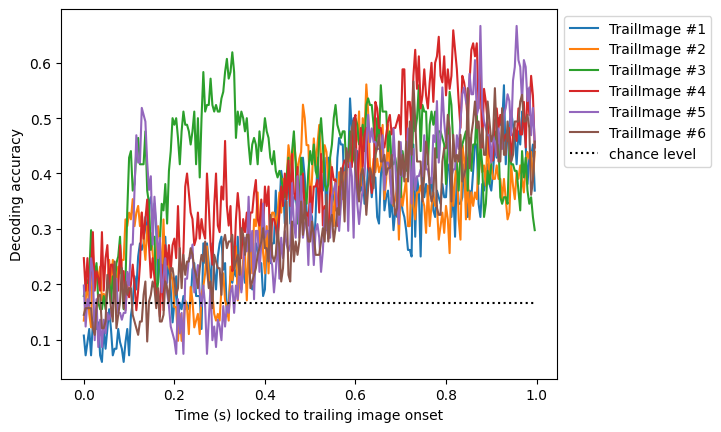

In [12]:
# Visualize 
iTrailImg = epochs.metadata['iTrailImg'].to_numpy()
times = epochs.times - tS2
for iTrail in np.unique( iTrailImg ):
    corr = np.mean( correct_trl[ :, iTrailImg==iTrail, :], axis=1 )
    plt.plot( times, corr, label=f"TrailImage #{iTrail}")
plt.plot( times, np.ones(times.shape)*(1/6), "k:", label="chance level")
plt.ylabel("Decoding accuracy")
plt.xlabel("Time (s) locked to trailing image onset")
plt.legend(bbox_to_anchor=(1.0,1.0))

**QUESTION:** I notice that the decoding accuracy goes up towards the end of the trial. Is this what to expect? The accuracy level looks reasonable to be that it starts at around chance level at t=0 and shows an ERF-like shape at around t=0.15 though. 

**COMMENT:** Going back to my earlier question re state path, it'd be very useful to have some pre-stimulus "baseline" window as reference. 

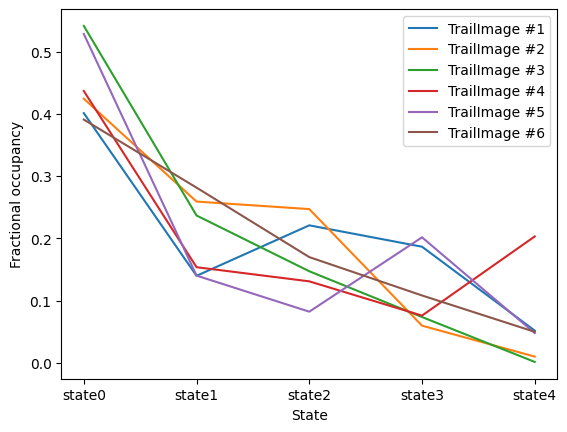

In [27]:
# ========= HMM model estimates for different conditions ========
# fractional occupancy by condition: fo_conds['E'].shape is (n_states, )
fo_conds = get_conditioned_metric(vpath, ind, metric="FO",
                                    condition=epochs.metadata['iTrailImg'].to_numpy())

# state onset (so) by condition: so_conds['E'].shape is (n_states, )
so_conds = get_conditioned_metric(vpath, ind, metric="state_onsets",
                                    condition=epochs.metadata['iTrailImg'].to_numpy())

# life time (lf) by condition: lf_conds['E'].shape is (n_states, )
lf_conds = get_conditioned_metric(vpath, ind, metric="life_times",
                                    condition=epochs.metadata['iTrailImg'].to_numpy())

# Visualize
for iTrail in fo_conds.keys():
    plt.plot( fo_conds[iTrail], label=f"TrailImage #{iTrail}")
plt.ylabel("Fractional occupancy")
plt.xlabel("State")
plt.xticks(np.arange(K), [f"state{k}" for k in range(K)])
plt.legend(bbox_to_anchor=(1.0,1.0))

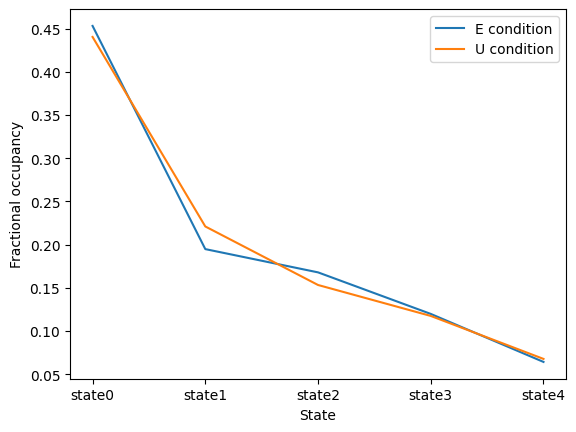

In [29]:
# ========= HMM model estimates for different conditions ========
'''
We are more interested in the difference between experimental manipulations, 
rathen then the difference between these images per se. 
'''
# fractional occupancy by condition: fo_conds['E'].shape is (n_states, )
fo_conds = get_conditioned_metric(vpath, ind, metric="FO",
                                    condition=epochs.metadata['condition'].to_numpy())

# state onset (so) by condition: so_conds['E'].shape is (n_states, )
so_conds = get_conditioned_metric(vpath, ind, metric="state_onsets",
                                    condition=epochs.metadata['condition'].to_numpy())

# life time (lf) by condition: lf_conds['E'].shape is (n_states, )
lf_conds = get_conditioned_metric(vpath, ind, metric="life_times",
                                    condition=epochs.metadata['condition'].to_numpy())

# Visualize: plotting for "Expected" and "Unexpected" conditions
for cond in ["E","U"]:
    plt.plot( fo_conds[cond], label=f"{cond} condition")
plt.ylabel("Fractional occupancy")
plt.xlabel("State")
plt.xticks(np.arange(K), [f"state{k}" for k in range(K)])
plt.legend(bbox_to_anchor=(1.0,1.0))